# This Notebook contains a PCA based analysis of the baseline corrected dataset and a K-Nearest Neighbor(KNN) classifier implementation to classify the Raman Spectra

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
## LOAD the data
mat_data=loadmat('BaselineCorrectedData2')
waveNumber=mat_data['waveNumber']
y_original=mat_data['has_DM2']
x_vein=mat_data['veinData']
x_earLobe=mat_data['earData']
x_Thumbnail=mat_data['nailData']
x_innerArm=mat_data['innerArmData']
print(type(x_vein),x_vein.dtype)
print(y_original)
print(y_original.shape)
print(type(y_original),y_original.dtype)

<class 'numpy.ndarray'> float64
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
(20, 1)
<class 'numpy.ndarray'> uint8


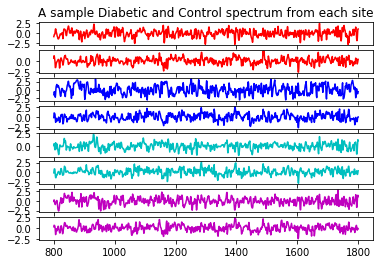

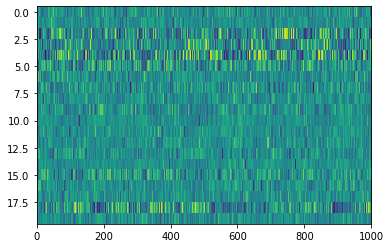

In [3]:
plt.figure()
plt.subplot(8,1,1)
plt.title('A sample Diabetic and Control spectrum from each site')
plt.plot(waveNumber,x_vein[0],'r')
plt.subplot(8,1,2)
plt.plot(waveNumber,x_vein[12],'r')

plt.subplot(8,1,3)
#plt.title('A sample Diabetic and Control earLobe spectrum')
plt.plot(waveNumber,x_earLobe[0],'b')
plt.subplot(8,1,4)
plt.plot(waveNumber,x_earLobe[12],'b')

plt.subplot(8,1,5)
#plt.title('A sample Diabetic and Control Thumbnail spectrum')
plt.plot(waveNumber,x_Thumbnail[0],'c')
plt.subplot(8,1,6)
plt.plot(waveNumber,x_Thumbnail[12],'c')

plt.subplot(8,1,7)
#plt.title('A sample Diabetic and Control innerArm spectrum')
plt.plot(waveNumber,x_innerArm[0],'m')
plt.subplot(8,1,8)
plt.plot(waveNumber,x_innerArm[12],'m')

plt.savefig('Images/Sample_Spectra.png')
plt.show()
plt.imshow(x_vein,aspect='auto')
plt.show()

# PCA Within each dataset

----------We are Investigating the file : vein --------
The length of rho: 20
The First Principle Component accounts for, 20.26871751269561 %Variance


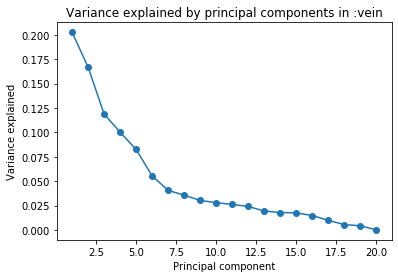

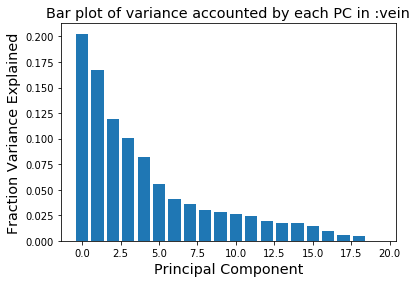

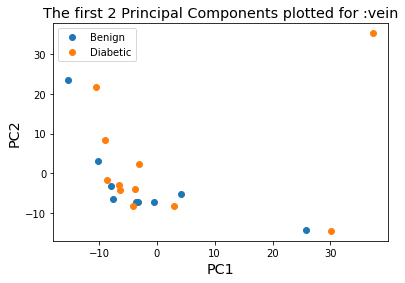

----------We are Investigating the file : earLobe --------
The length of rho: 20
The First Principle Component accounts for, 30.80851751561501 %Variance


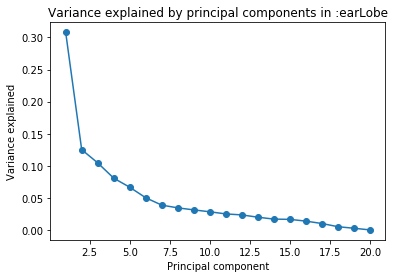

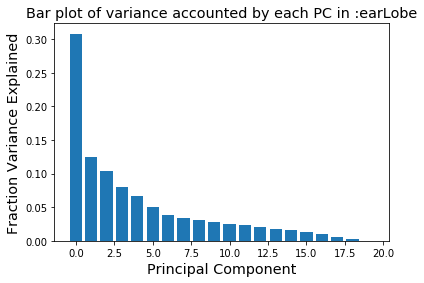

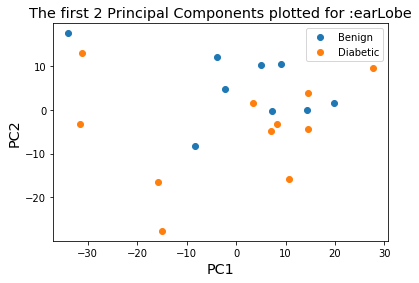

----------We are Investigating the file : Thumbnail --------
The length of rho: 20
The First Principle Component accounts for, 24.681460347562968 %Variance


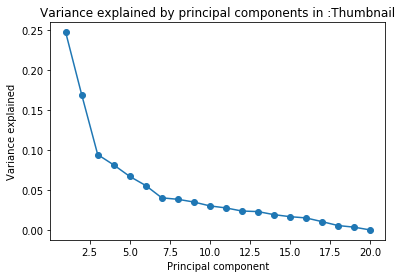

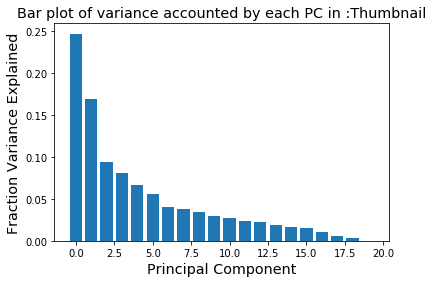

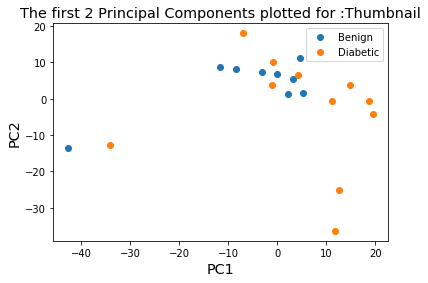

----------We are Investigating the file : innerArm --------
The length of rho: 20
The First Principle Component accounts for, 27.26732954487091 %Variance


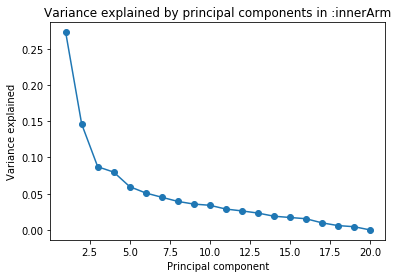

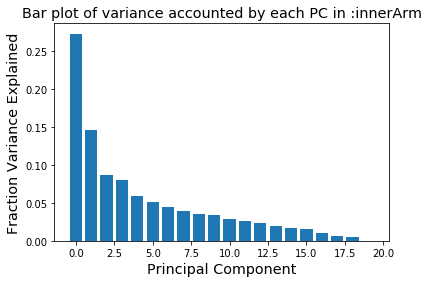

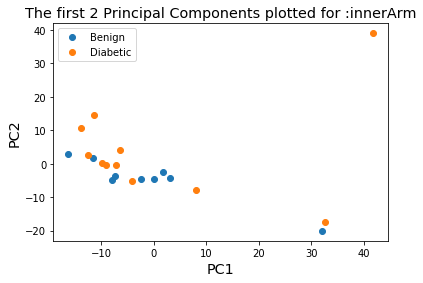

In [4]:
#Checking within each file for a easy decision boundary.
y=y_original
i=0
Filename=['vein','earLobe','Thumbnail','innerArm']
num_classes=2
for X in [x_vein,x_earLobe,x_Thumbnail,x_innerArm]:
    X=X.astype('float32')
    y=y.astype('int32')

    print("----------We are Investigating the file :",Filename[i],"--------")
    
    N=X.shape[0]
    #Subtracting Mean to center the Data
    from scipy.linalg import svd
    X_MeanCentered = X - np.ones((N,1))*X.mean(0)

    # PCA by computing SVD of Y
    U,S,V = svd(X_MeanCentered,full_matrices=False)

    # Compute variance explained by principal components
    rho = (S*S) / (S*S).sum() 
    print("The length of rho:",len(rho))
    print("The First Principle Component accounts for,",rho[0]*100,"%Variance")

    # Plot the variance explained
    plt.figure()
    plt.plot(range(1,len(rho)+1),rho,'o-')
    #plt.rcParams['figure.figsize']=(20,15)
    #plt.xticks(np.arange(0,64,1))
    plt.title('Variance explained by principal components in :'+Filename[i]);
    plt.xlabel('Principal component');
    plt.ylabel('Variance explained');
    plt.show()

    #plotting the bar graph for the same.
    plt.figure()
    plt.title('Bar plot of variance accounted by each PC in :'+Filename[i],fontsize='x-large')
    plt.bar(range(len(rho)),rho)
    plt.xlabel('Principal Component',fontsize='x-large')
    plt.ylabel('Fraction Variance Explained',fontsize='x-large')
    plt.savefig('Images/BarPlot_VarianceExplained:'+Filename[i]+'.png')
    plt.show()

    #Taking projection over PC1 and PC2
    j=2  #Number of Principal Components to be plotted
    V_reduced=V.T[:,0:j]
    X_Projected=X_MeanCentered@V_reduced

    #making scatter plot of the different classes on PC1 and PC2
    for c in range(num_classes):
        # select indices belonging to class c:
        class_mask = y.ravel()==c
        plt.plot(X_Projected[class_mask,0],X_Projected[class_mask,1] ,'o')  
    #plt.legend(np.unique(y))    
    plt.legend(['Benign','Diabetic'])
    plt.title('The first 2 Principal Components plotted for :'+Filename[i],fontsize='x-large')
    plt.xlabel('PC1',fontsize='x-large')
    plt.ylabel('PC2',fontsize='x-large')
    plt.savefig('Images/Data_Plotted_onPC:'+Filename[i]+'.png')
    plt.show()
    i+=1

# Visualising a decision Boundary - This is just for visualising a non-linear decision boundary

In [5]:
from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.metrics import accuracy_score

In [6]:
def plot_decision_boundary(pred_func, X, y):
    #from https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    h = 1
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    yy = yy.astype('float32')
    xx = xx.astype('float32')
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])#[:,0]
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=-y, cmap=plt.cm.Spectral)




In [7]:
#Doing a random Shuffle on the dataset
X=x_vein.astype('float32')
print(X.shape)
y=y.reshape(20,1)
X=np.append(X,y,axis=1)
print(X.shape)
np.random.shuffle(X)
y=X[:,1001]
X=X[:,:1001]
print(y.dtype)
print(y.shape)
y=y.astype('int32')
print(y)

(20, 1001)
(20, 1002)
float64
(20,)
[1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1]


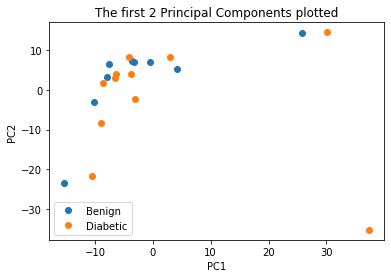

(20, 2)
(20, 2) (20,)


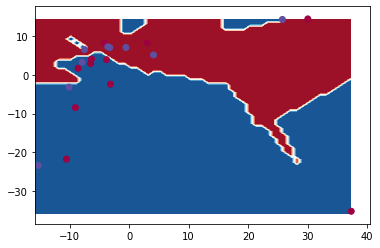

In [8]:

#Centering the Data for PCA
X_MeanCentered = X - np.ones((N,1))*X.mean(0)

# PCA by computing SVD of Y
U,S,V = svd(X_MeanCentered,full_matrices=False)
j=2  #Number of Principal Components to be plotted
V_reduced=V.T[:,0:j]
X_Projected=X_MeanCentered@V_reduced
for c in range(num_classes):
    # select indices belonging to class c:
    class_mask = y.ravel()==c
    plt.plot(X_Projected[class_mask,0],X_Projected[class_mask,1] ,'o') 
#plt.legend(np.unique(y))    
plt.legend(['Benign','Diabetic'])
plt.title('The first 2 Principal Components plotted')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#plotting the contour boundary
print(X_Projected.shape)
x_train=X_Projected[:20,:]
y_train=y[:20].ravel()
x_test=X_Projected[10:20,:]
y_test=y[10:20].ravel()
print(x_train.shape,y_train.shape)
knclassifier=KNeighborsClassifier(n_neighbors=3)
knclassifier.fit(x_train,y_train)

plot_decision_boundary(lambda x:knclassifier.predict(x), x_train, y_train)

# Using KNN on each Dataset with the Reduced Components

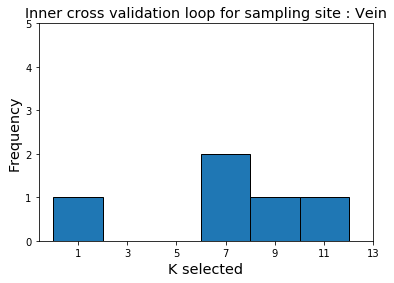

THE AVERAGE ACCURACY ON THE OUTER LOOP IS : 0.15




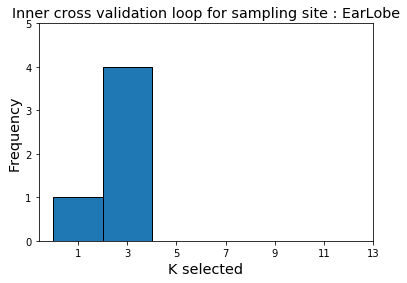

THE AVERAGE ACCURACY ON THE OUTER LOOP IS : 0.65




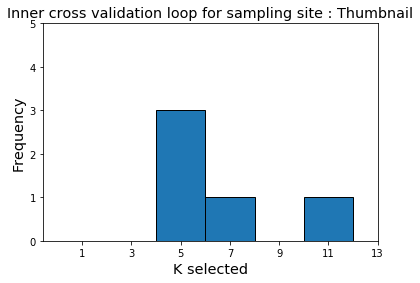

THE AVERAGE ACCURACY ON THE OUTER LOOP IS : 0.25




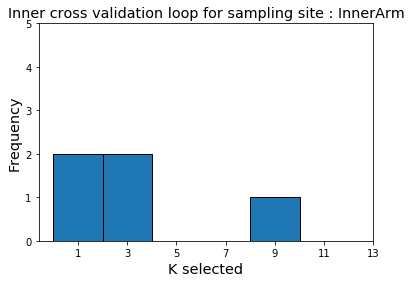

THE AVERAGE ACCURACY ON THE OUTER LOOP IS : 0.3




In [9]:
f=0
Filename=['Vein','EarLobe','Thumbnail','InnerArm']
for data in [x_vein,x_earLobe,x_Thumbnail,x_innerArm]:
    #indicating what file is being read
    #print('--------Sampling Site :',Filename[f],"-----------")
    
    #just making sure that proper data is recorded inside the loop
    y=y_original
    X=data
    
    X=np.append(X,y,axis=1)
    np.random.shuffle(X)
    
    y=X[:,1001].astype('uint8')
    X=X[:,:1001]
    
    L = 11    #maximum number of neighbors to be considered
    num_splits = 5 #AKA 5-fold cross validation
    CV2 = model_selection.KFold(n_splits=num_splits)
    CV = model_selection.LeaveOneOut()
    #errors = np.zeros((N,L))
    fold=0
    total_acc=[]
    best_K_selected=[]
    for train_indices,test_indices in CV2.split(X):
        #print('Crossvalidation fold: {0}/{1}'.format(fold+1,num_splits))
        X_train=X[train_indices]
        y_train=y[train_indices]
        X_test=X[test_indices]
        y_test=y[test_indices]
        
        #PCA section
        N=X_train.shape[0]  # the definition of N changes later in the inner loops
        # Centering the data for Doing PCA
        X_MeanCenteredtrain = X_train - np.ones((N,1))*X_train.mean(0)
        # PCA by computing SVD of Y
        U,S,V = svd(X_MeanCenteredtrain,full_matrices=False)
        rho = (S*S) / (S*S).sum() 
        #plt.title('Fraction Cumulative variance explained v/s principal component')
        #plt.plot(np.cumsum(rho))
        #plt.axvline(x=2.5)
        #plt.show()
         
        a=rho[np.where(np.cumsum(rho)<=0.95)]
        #print("To account for 95% variance, we have taken the first",a.shape[0],"components")
        j=a.shape[0] #Number of Principal Components to be plotted
        V_reduced=V.T[:,0:j]
        X_Projectedtrain=X_MeanCenteredtrain@V_reduced
        
        N=X_test.shape[0]
        X_MeanCenteredtest = X_test - np.ones((N,1))*X_train.mean(0)
        X_Projectedtest=X_MeanCenteredtest@V_reduced #projecting on the principal components of the training data
        
        i=0
        N=X_train.shape[0]
        errors=np.zeros((N,L))
        for train_index, test_index in CV.split(X_train):
            # extract training and test set for current CV fold
            X_train_inner = X_train[train_index]
            y_train_inner = y_train[train_index]
            X_test_inner = X_train[test_index]
            y_test_inner = y_train[test_index]
            
            N=X_train_inner.shape[0]
            X_MeanCenteredtraininner = X_train_inner - np.ones((N,1))*X_train_inner.mean(0)
            # PCA by computing SVD of Y
            U,S,V = svd(X_MeanCenteredtraininner,full_matrices=False)
            rho = (S*S) / (S*S).sum() 
            a=rho[np.where(np.cumsum(rho)<=0.95)]
            #print("To account for 95% variance, we have taken the first",a.shape[0],"components")
            #j=a.shape[0] #Number of Principal Components to be plotted
            j=10
            V_reduced=V.T[:,0:j]
            X_Projectedtraininner=X_MeanCenteredtraininner@V_reduced
            
            X_MeanCenteredtestinner = X_test_inner - X_train_inner.mean(0)
            X_Projectedtestinner=X_MeanCenteredtestinner@V_reduced
            #print(test_index)
            # Fit classifier and classify the test points
            #(consider 1 to L number of neighbors) to choose best L
            for l in range(1,L+1,2):
                knclassifier = KNeighborsClassifier(n_neighbors=l);
                knclassifier.fit(X_Projectedtraininner, y_train_inner);
                y_est_inner = knclassifier.predict(X_Projectedtestinner);
                errors[i,l-1] = np.sum(y_est_inner[0]!=y_test_inner[0])
            i+=1
        #Choose the best K here and test the accuracy of it here:-
        #Plot the classification error rate per K
        errors_relevant=errors[:,slice(0,L+1,2)] #take the even numbered elements
        TotalErrors_PerK=sum(errors_relevant,0)/N   
        #plt.figure()
        x_num=np.arange(1,L+1,2)
        #plt.plot(x_num,TotalErrors_PerK,'--or')
        #plt.xlabel('Number of neighbors')
        #plt.ylabel('Classification error rate %')
        #plt.xticks(np.arange(1,l+1,2))
        #plt.show()

        fold+=1 #for indicating what fold we are in
        best_k=2*np.argmin(TotalErrors_PerK)+1
        #print("The best selected K in this fold is",best_k)
        knclassifier = KNeighborsClassifier(n_neighbors=best_k);
        knclassifier.fit(X_Projectedtrain, y_train);
        y_est = knclassifier.predict(X_Projectedtest);
        total_acc.append(accuracy_score(y_test,y_est))
        #print("The accuracy of this fold is",accuracy_score(y_test,y_est))
        best_K_selected.append(best_k)
    #print(best_K_selected) 
    plt.hist(best_K_selected,bins=range(0,L+3,2),edgecolor='black',align='mid')
    plt.xticks(range(1,L+3,2))
    plt.yticks(range(6))
    plt.xlabel('K selected',fontsize='x-large')
    plt.ylabel('Frequency',fontsize='x-large')
    plt.title('Inner cross validation loop for sampling site : '+Filename[f],fontsize='x-large')
    plt.show()
    print("THE AVERAGE ACCURACY ON THE OUTER LOOP IS :",sum(total_acc)/len(total_acc))
    f+=1
    print()
    print()

# KNN using all the Dataset + PCA to classify 2 classes

In [10]:
#Mixing all the dataset together
X_vein_earLobe=np.append(x_vein,x_earLobe,axis=0)
X_Thumbnail_innerArm=np.append(x_Thumbnail,x_innerArm,axis=0)
X=np.append(X_vein_earLobe,X_Thumbnail_innerArm,axis=0)
print(X.shape)
Y=y_original
for i in range(3):
    y=y_original
    Y=np.append(Y,y,axis=0)
print(Y.shape)
print(Y.ravel())


#Randomly reshuffling the data
#y=y.reshape(20,1)
X=np.append(X,Y,axis=1)
print(X.shape)
np.random.shuffle(X)
Y=X[:,1001].astype('uint8')
X=X[:,:1001]
print("Final X shape:",X.shape)
print("The Y's finally after shuffling:",Y,Y.dtype)


(80, 1001)
(80, 1)
[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0]
(80, 1002)
Final X shape: (80, 1001)
The Y's finally after shuffling: [1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1
 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1
 1 0 0 1 1 0] uint8


The length of rho: 80
The First Principle Component accounts for, 22.805197226384564 %Variance


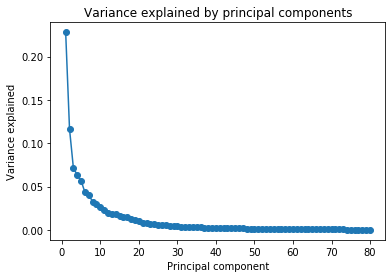

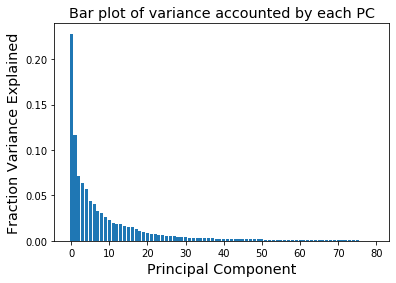

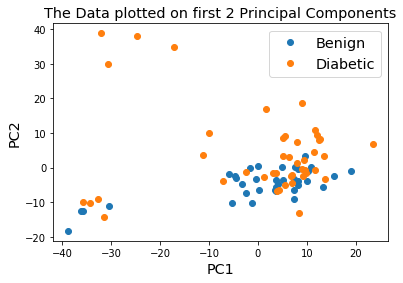

In [11]:
#PCA on all the dataset to visualise plot with PC1 and PC2
N=X.shape[0]
#Subtracting Mean to center the Data
from scipy.linalg import svd
X_MeanCentered = X - np.ones((N,1))*X.mean(0)

# PCA by computing SVD of Y
U,S,V = svd(X_MeanCentered,full_matrices=False)

# Compute variance explained by principal components
rho = (S*S) / (S*S).sum() 
print("The length of rho:",len(rho))
print("The First Principle Component accounts for,",rho[0]*100,"%Variance")

# Plot the variance explained
plt.figure()
plt.plot(range(1,len(rho)+1),rho,'o-')
#plt.rcParams['figure.figsize']=(20,15)
#plt.xticks(np.arange(0,64,1))
plt.title('Variance explained by principal components');
plt.xlabel('Principal component');
plt.ylabel('Variance explained');
plt.show()

#plotting the bar graph for the same.
plt.title('Bar plot of variance accounted by each PC',fontsize='x-large')
plt.bar(range(len(rho)),rho)
plt.xlabel('Principal Component',fontsize='x-large')
plt.ylabel('Fraction Variance Explained',fontsize='x-large')
plt.savefig('Images/FractionVariance_FullDataset.png')
plt.show()

#Taking projection over PC1 and PC2
j=2  #Number of Principal Components to be plotted
V_reduced=V.T[:,0:j]
X_Projected=X_MeanCentered@V_reduced

#making scatter plot of the different classes on PC1 and PC2
for c in range(num_classes):
    # select indices belonging to class c:
    class_mask = Y.ravel()==c
    plt.plot(X_Projected[class_mask,0],X_Projected[class_mask,1] ,'o')  
#plt.legend(np.unique(Y))    
plt.legend(['Benign','Diabetic'],fontsize='x-large')
plt.xlabel('PC1',fontsize='x-large')
plt.ylabel('PC2',fontsize='x-large')
plt.title('The Data plotted on first 2 Principal Components',fontsize='x-large')
plt.savefig('Images/PCA_Scatterplot_FullDataset.png')
plt.show()

Crossvalidation fold: 1/5
To account for 95% variance, we have taken the first 32 components
The best selected K in this fold is 1
The accuracy of this fold is 0.875
Crossvalidation fold: 2/5
To account for 95% variance, we have taken the first 31 components
The best selected K in this fold is 3
The accuracy of this fold is 0.75
Crossvalidation fold: 3/5
To account for 95% variance, we have taken the first 30 components
The best selected K in this fold is 1
The accuracy of this fold is 0.875
Crossvalidation fold: 4/5
To account for 95% variance, we have taken the first 31 components
The best selected K in this fold is 1
The accuracy of this fold is 0.8125
Crossvalidation fold: 5/5
To account for 95% variance, we have taken the first 31 components
The best selected K in this fold is 1
The accuracy of this fold is 1.0
THE ACCURACY OF KNN ON THIS FILE IS : 0.8625


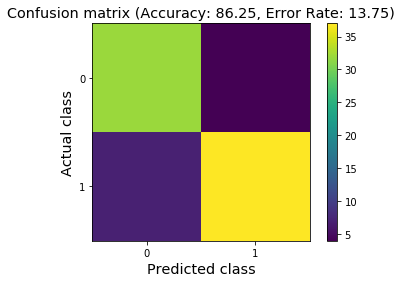

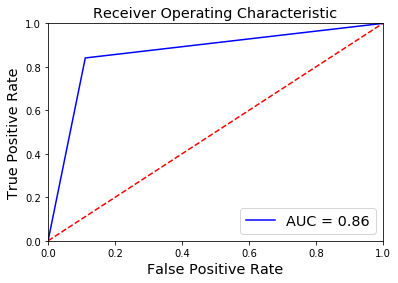

In [12]:
L = 11    #maximum number of neighbors to be considered
num_splits = 5 #AKA 5-fold cross validation
CV2 = model_selection.KFold(n_splits=num_splits)
CV = model_selection.LeaveOneOut()
fold=0
total_acc=[]
best_K_selected=[]
y_preds=[]
for train_indices,test_indices in CV2.split(X):
    print('Crossvalidation fold: {0}/{1}'.format(fold+1,num_splits))
    X_train=X[train_indices]
    y_train=Y[train_indices]
    X_test=X[test_indices]
    y_test=Y[test_indices]

    #PCA section
    N=X_train.shape[0]  # the definition of N changes later in the inner loops
    # Centering the data for Doing PCA
    X_MeanCenteredtrain = X_train - np.ones((N,1))*X_train.mean(0)
    # PCA by computing SVD of Y
    U,S,V = svd(X_MeanCenteredtrain,full_matrices=False)
    rho = (S*S) / (S*S).sum() 
    #plt.title('Fraction Cumulative variance explained v/s principal component')
    #plt.plot(np.cumsum(rho))
    #plt.axvline(x=2.5)
    #plt.show()

    a=rho[np.where(np.cumsum(rho)<=0.95)]
    print("To account for 95% variance, we have taken the first",a.shape[0],"components")
    j=a.shape[0] #Number of Principal Components to be plotted
    V_reduced=V.T[:,0:j]
    X_Projectedtrain=X_MeanCenteredtrain@V_reduced

    N=X_test.shape[0]
    X_MeanCenteredtest = X_test - np.ones((N,1))*X_train.mean(0)
    X_Projectedtest=X_MeanCenteredtest@V_reduced #projecting on the principal components of the training data

    i=0
    N=X_train.shape[0]
    errors=np.zeros((N,L))
    for train_index, test_index in CV.split(X_train):
        # extract training and test set for current CV fold
        X_train_inner = X_train[train_index]
        y_train_inner = y_train[train_index]
        X_test_inner = X_train[test_index]
        y_test_inner = y_train[test_index]

        N=X_train_inner.shape[0]
        X_MeanCenteredtraininner = X_train_inner - np.ones((N,1))*X_train_inner.mean(0)
        # PCA by computing SVD of Y
        U,S,V = svd(X_MeanCenteredtraininner,full_matrices=False)
        rho = (S*S) / (S*S).sum() 
        a=rho[np.where(np.cumsum(rho)<=0.95)]
        #print("To account for 95% variance, we have taken the first",a.shape[0],"components")
        j=a.shape[0] #Number of Principal Components to be plotted
        #j=10
        V_reduced=V.T[:,0:j]
        X_Projectedtraininner=X_MeanCenteredtraininner@V_reduced

        X_MeanCenteredtestinner = X_test_inner - X_train_inner.mean(0)
        X_Projectedtestinner=X_MeanCenteredtestinner@V_reduced
        #print(test_index)
        # Fit classifier and classify the test points
        #(consider 1 to L number of neighbors) to choose best L
        for l in range(1,L+1,2):
            knclassifier = KNeighborsClassifier(n_neighbors=l);
            knclassifier.fit(X_Projectedtraininner, y_train_inner);
            y_est_inner = knclassifier.predict(X_Projectedtestinner);
            errors[i,l-1] = np.sum(y_est_inner[0]!=y_test_inner[0])
        i+=1
    #Choose the best K here and test the accuracy of it here:-
    #Plot the classification error rate per K
    errors_relevant=errors[:,slice(0,L+1,2)] #take the even numbered elements
    TotalErrors_PerK=sum(errors_relevant,0)/N   
    #plt.figure()
    x_num=np.arange(1,L+1,2)
    
    
    #plt.plot(x_num,TotalErrors_PerK,'--or') 
    #plt.xlabel('Number of neighbors')
    #plt.ylabel('Classification error rate %')
    #plt.xticks(np.arange(1,l+1,2))
    #plt.show()
    
    fold+=1 #for indicating what fold we are in
    best_k=2*np.argmin(TotalErrors_PerK)+1
    print("The best selected K in this fold is",best_k)
    knclassifier = KNeighborsClassifier(n_neighbors=best_k);
    knclassifier.fit(X_Projectedtrain, y_train);
    y_est = knclassifier.predict(X_Projectedtest);
    total_acc.append(accuracy_score(y_test,y_est))
    print("The accuracy of this fold is",accuracy_score(y_test,y_est))
    best_K_selected.append(best_k)
    y_preds += list(y_est)
#print(best_K_selected) 
#plt.hist(best_K_selected,bins=range(0,L+3,2),edgecolor='black',align='mid')
#plt.xticks(range(1,L+3,2))
#plt.yticks(range(6))
#plt.xlabel('K selected')
#plt.ylabel('frequency')
#plt.title('Histogram of selected K in every inner loop')
#plt.show()
print("THE ACCURACY OF KNN ON THIS FILE IS :",sum(total_acc)/len(total_acc))


C=num_classes
cm = confusion_matrix(Y, y_preds);
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
plt.figure(2);
plt.imshow(cm, interpolation='None');
plt.colorbar()
plt.xticks(range(C)); plt.yticks(range(C));
plt.xlabel('Predicted class',fontsize='x-large'); plt.ylabel('Actual class',fontsize='x-large');
plt.title('Confusion matrix (Accuracy: {:04.2f}, Error Rate: {:4.2f})'.format(accuracy, error_rate),fontsize='x-large');
plt.savefig('Images/ConfusionMatrix_PCAKNN.png')
plt.show()
print()
print()



import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
#probs = model.predict_proba(X_test)
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y, y_preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic',fontsize='x-large')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right',fontsize='x-large')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize='x-large')
plt.xlabel('False Positive Rate',fontsize='x-large')
plt.savefig('Images/ROCcurve_PCAKNN.png')
plt.show()





In [13]:
cm

array([[32,  4],
       [ 7, 37]])

# KNN on entire dataset without PCA

In [14]:
from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.metrics import accuracy_score

Crossvalidation fold: 1/5
The best selected K in this fold is 1
The accuracy of this fold is 0.6875
Crossvalidation fold: 2/5
The best selected K in this fold is 3
The accuracy of this fold is 0.8125
Crossvalidation fold: 3/5
The best selected K in this fold is 1
The accuracy of this fold is 0.9375
Crossvalidation fold: 4/5
The best selected K in this fold is 1
The accuracy of this fold is 0.875
Crossvalidation fold: 5/5
The best selected K in this fold is 1
The accuracy of this fold is 0.9375
[1, 3, 1, 1, 1]


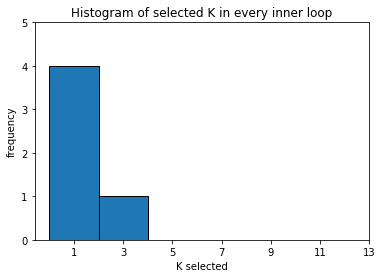

THE ACCURACY OF KNN ON THIS FILE IS : 0.85


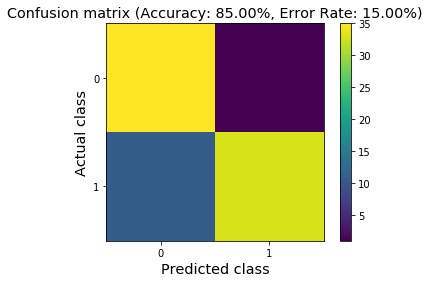

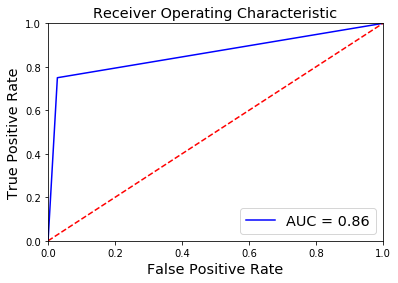

In [17]:
#2-layer cross validation on the entire dataset to compute the models expected performance
L = 11    #maximum number of neighbors to be considered
num_splits = 5 #AKA 5-fold cross validation
CV2 = model_selection.KFold(n_splits=num_splits)
CV = model_selection.LeaveOneOut()
j=0
total_acc=[]
y_preds=[]
best_K_selected=[]
for train_indices,test_indices in CV2.split(X):
    print('Crossvalidation fold: {0}/{1}'.format(j+1,num_splits))
    X_train=X[train_indices]
    y_train=Y[train_indices]
    X_test=X[test_indices]
    y_test=Y[test_indices]

    i=0
    N=X_train.shape[0]
    errors=np.zeros((N,L))
    for train_index, test_index in CV.split(X_train):
        # extract training and test set for current CV fold
        X_train_inner = X_train[train_index]
        y_train_inner = y_train[train_index]
        X_test_inner = X_train[test_index]
        y_test_inner = y_train[test_index]
        #print(test_index)
        # Fit classifier and classify the test points
        #(consider 1 to L number of neighbors) to choose best L
        for l in range(1,L+1,2):
            knclassifier = KNeighborsClassifier(n_neighbors=l);
            knclassifier.fit(X_train_inner, y_train_inner);
            y_est_inner = knclassifier.predict(X_test_inner);
            errors[i,l-1] = np.sum(y_est_inner[0]!=y_test_inner[0])
        i+=1
    #Choose the best K here and test the accuracy of it here:-
    # Plot the classification error rate per K
    errors_relevant=errors[:,slice(0,L+1,2)] #take the even numbered elements
    TotalErrors_PerK=sum(errors_relevant,0)/N   
    #plt.figure()
    x_num=np.arange(1,L+1,2)
    #uncomment the following lines to get the image as in the report
    #plt.plot(x_num,TotalErrors_PerK,'--or')
    #plt.xlabel('Number of neighbors')
    #plt.ylabel('Classification error rate %')
    #plt.xticks(np.arange(1,l+1,2))
    #plt.show()

    j+=1 #for indicating what fold we are in
    best_k=2*np.argmin(TotalErrors_PerK)+1
    print("The best selected K in this fold is",best_k)
    knclassifier = KNeighborsClassifier(n_neighbors=best_k);
    knclassifier.fit(X_train, y_train);
    y_est = knclassifier.predict(X_test);
    total_acc.append(accuracy_score(y_test,y_est))
    print("The accuracy of this fold is",accuracy_score(y_test,y_est))
    #print(y_est)
    y_preds+= list(y_est)
    #print(y_preds)
    best_K_selected.append(best_k)
print(best_K_selected)
plt.hist(best_K_selected,bins=range(0,L+3,2),edgecolor='black',align='mid')
plt.xticks(range(1,L+3,2))
plt.yticks(range(6))
plt.xlabel('K selected')
plt.ylabel('frequency')
plt.title('Histogram of selected K in every inner loop')
plt.show()
print("THE ACCURACY OF KNN ON THIS FILE IS :",sum(total_acc)/len(total_acc))

C=num_classes
cm = confusion_matrix(Y, y_preds);
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
plt.figure(2);
plt.imshow(cm, interpolation='None');
plt.colorbar()
plt.xticks(range(C)); plt.yticks(range(C));
plt.xlabel('Predicted class',fontsize='x-large'); plt.ylabel('Actual class',fontsize='x-large');
plt.title('Confusion matrix (Accuracy: {:4.2f}%, Error Rate: {:4.2f}%)'.format(accuracy, error_rate),fontsize='x-large');
plt.savefig('Images/ConfusionMatrix_FullDataset.png')
plt.show()


import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
#probs = model.predict_proba(X_test)
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y, y_preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic',fontsize='x-large')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right',fontsize='x-large')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize='x-large')
plt.xlabel('False Positive Rate',fontsize='x-large')
plt.savefig('Images/ROCCurve_FullDataset.png')
plt.show()



In [18]:
cm

array([[35,  1],
       [11, 33]])